<b>Fixed strike lookback option and option on collateralized loan under jump-diffusion process </b>

<b>1. Fixed strike lookback option </b>

In [3]:
print("1.Define function")

import numpy as np
import matplotlib.pyplot as plt

# Instead of using the random function in python, we build up the succession of “pseudorandom” numbers
# using Lewis Goodman, Miller- IBM (LGM) method. We generate uniformly distributed random variables on [0,1].
def uniform(n):
    m=(2**31)-1
    a=7**5
    lgmnum=[9]*n
    for i in range(n-1):
        lgmnum[i+1]=(lgmnum[i]*a)%m
    uniformrand=np.array(lgmnum)/m
    return uniformrand

#  We generate n standard normally distributed random variables by Box-Muller method using the uniform variables.
def normal(uniformrand,n): 
    Z1=[0]*int(n)
    Z2=[0]*int(n)
    for i in range(int(n)):
        Z1[i]=np.sqrt(-2*np.log(uniformrand[2*i]))*np.cos(2*np.pi*uniformrand[2*i+1])
        Z2[i]=np.sqrt(-2*np.log(uniformrand[2*i]))*np.sin(2*np.pi*uniformrand[2*i+1])  
    return np.hstack((Z1,Z2))    

# Build the fixed strike lookback option
def FixK_LookBack(S0,r,sigma,T,sim,N,type):
    dt=T/N
    randu=uniform(int(N*sim))
    randn=normal(randu,int(sim*N/2))
    Z=np.reshape(randn,(int(sim),N))
    S=np.zeros((sim,N+1))
    S[:,0]=S0
    for i in range(1,N+1):
        S[:,i]=S[:,i-1]*np.exp((r-0.5*sigma**2)*dt+sigma*dt**0.5*Z[:,i-1])
    if type=="call":
        payoff=np.max(S,axis=1)-S[:,N]
    elif type=="put":
        payoff=S[:,N]-np.min(S,axis=1)
    put=np.clip(payoff,0,np.max(payoff))*np.exp(-r*T)
    putprice=np.mean(put)
    return putprice

1.Define function


Use Monte Carlo simulation to price fixed strike lookback call/put options under different volatility.

1.Running results and plotting


<Figure size 432x288 with 0 Axes>

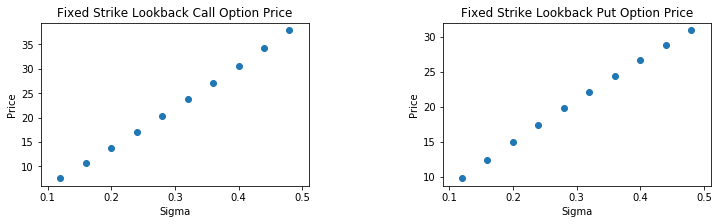

In [4]:
print("1.Running results and plotting")
S0,r,sigma,T,sim,N=98,0.03,np.round(np.arange(0.12,0.481,0.04),2),1,10000,100
FixK_Lookback_Call=[0]*len(list(sigma))
FixK_Lookback_Put=[0]*len(list(sigma))
i=0
for sigma_1 in sigma:
    FixK_Lookback_Call[i]=FixK_LookBack(S0,r,sigma_1,T,sim,N,"call")
    FixK_Lookback_Put[i]=FixK_LookBack(S0,r,sigma_1,T,sim,N,"put")
    i=i+1

plt.figure()
plt.figure(figsize=(12,3))
plt.subplots_adjust(wspace=0.5)
plt.subplot(121)
plt.scatter(sigma,FixK_Lookback_Call)
plt.xlabel("Sigma")
plt.ylabel("Price")
plt.title("Fixed Strike Lookback Call Option Price")
plt.subplot(122)
plt.scatter(sigma,FixK_Lookback_Put)
plt.xlabel("Sigma")
plt.ylabel("Price")
plt.title("Fixed Strike Lookback Put Option Price")
plt.show()

<b>2. Pricing option on collateralized loan under jump-diffusion process</b>

The value of collateral follows a jump-diffusion process.Payoff is (collateralized_loan - epsilon * collateral_value). Exercise time is the first time when the relative value of the collateral crosses a threshold.

In [2]:
print("2.Define function")

# Define poisson proecss
def GenPoisson(randu,gamma,N):
    randP=[0]*N
    for i in range(N):
        z=np.exp(-gamma)
        k=0
        x=z
        while randu[i]>=x:
            z=gamma/(k+1)*z
            x=x+z
            k=k+1
        randP[i]=k
    return randP

# Build the collateralized loan option model under jump-diffusion process using Monte Carlo
# The model returns the default option price, the default probability and the expected exercise time
probability and the expected exercise time
def col_loan_jump_option(lambda1,lambda2,T,N,sim):
    V0,L0,miu,sigma,gamma=20000,22000,-0.1,0.2,-0.4
    r0,delta,alpha,epsilon=0.02,0.25,0.7,0.95
    R=r0+delta*lambda2
    r=R/12
    n=T*12
    PMT=L0*r/(1-(1+r)**(-n))
    a=PMT/r
    b=PMT/(r*(1+r)**n)
    c=(1+r)
    h=T/N
    randu=uniform(int(3*N*sim))
    randn=normal(randu[0:(N*sim)],int(sim*N/2))
    Z=np.reshape(randn,(sim,N))
    JP=GenPoisson(randu[(N*sim):(2*N*sim)],lambda1*h,sim*N)
    JP=np.reshape(JP,(sim,N))
    NP=GenPoisson(randu[(2*N*sim):],lambda2*h,sim*N)
    NP=np.reshape(NP,(sim,N))
    NPro=np.zeros((sim,N+1))
    NPro[:0]=0
    logV=np.zeros((sim,N+1))
    logV[:,0]=np.log(V0)
    V=np.zeros((sim,N+1))
    Q=[N+1]*sim
    S=[N+1]*sim
    price=[0]*sim
    tau=[N+1]*sim
    L=np.zeros((sim,N+1))
    L[:,0]=L0
    for i in range(N):
        logV[:,i+1]=logV[:,i]+(miu-0.5*sigma**2)*h+sigma*h**0.5*Z[:,i]+JP[:,i]*np.log(1+gamma)
        L[:,i+1]=a-b*c**(12*h*(i+1))
        NPro[:,i+1]=NPro[:,i]+NP[:,i]
        qt=alpha+(epsilon-alpha)/N*(i+1)
        for j in range(sim):
            if np.exp(logV[j,i+1])<=L[j,i+1]*qt and Q[j]==N+1:
                Q[j]=i+1
            if NPro[j,i+1]>0 and S[j]==N+1:
                S[j]=i+1
    V=np.exp(logV)
    for i in range(sim):
        if Q[i]<=S[i] and S[i]!=N+1:
            price[i]=max(L[i,Q[i]]-epsilon*V[i,Q[i]],0)*np.exp(-r0*Q[i]*h)
        elif Q[i]>S[i]:
            price[i]=abs(L[i,S[i]]-epsilon*V[i,S[i]])*np.exp(-r0*S[i]*h)
        elif Q[i]==S[i] and S[i]==N+1:
            price[i]=0
        tau[i]=min(Q[i],S[i])
    value=np.mean(np.array(price))
    ProbDefault=np.sum(np.array(tau)!=N+1)/sim
    tau.remove(N+1)
    EexerciseT=np.mean(np.array(tau))*h
    return value,ProbDefault,EexerciseT

2.Define function


Returen results of the default option model for given parameters

In [10]:
print("2(i).Running results")
N=100
sim=10000
valuei,ProbDefaulti,EexerciseTi=col_loan_jump_option(0.2,0.4,5,N,sim)   
print(valuei,ProbDefaulti,EexerciseTi)

2(i).Running results
4174.627572670149 0.9493 1.3664266426642664


Estimate value, default probability and expected exercise time of the default option for different parameters and plot the graphs.

In [11]:
print("2(ii).Plot")

T2=np.round(list(range(3,9,1)),0)
lambda2=np.round(list(np.arange(0,0.8001,0.1)),1)
lambda1=np.round(list(np.arange(0.05,0.4001,0.05)),2)
value1,ProbDefault1,EexerciseT1=np.zeros((len(lambda2),len(T2))),np.zeros((len(lambda2),len(T2))),np.zeros((len(lambda2),len(T2)))
value2,ProbDefault2,EexerciseT2=np.zeros((len(lambda1),len(T2))),np.zeros((len(lambda1),len(T2))),np.zeros((len(lambda1),len(T2)))

for i in range(len(lambda2)):
    for j in range(len(T2)):
        value1[i,j],ProbDefault1[i,j],EexerciseT1[i,j]=col_loan_jump_option(0.1,lambda2[i],T2[j],N,sim)

for i in range(len(lambda1)):
    for j in range(len(T2)):
        value2[i,j],ProbDefault2[i,j],EexerciseT2[i,j]=col_loan_jump_option(lambda1[i],0.4,T2[j],N,sim)

2(ii).Plot


<Figure size 432x288 with 0 Axes>

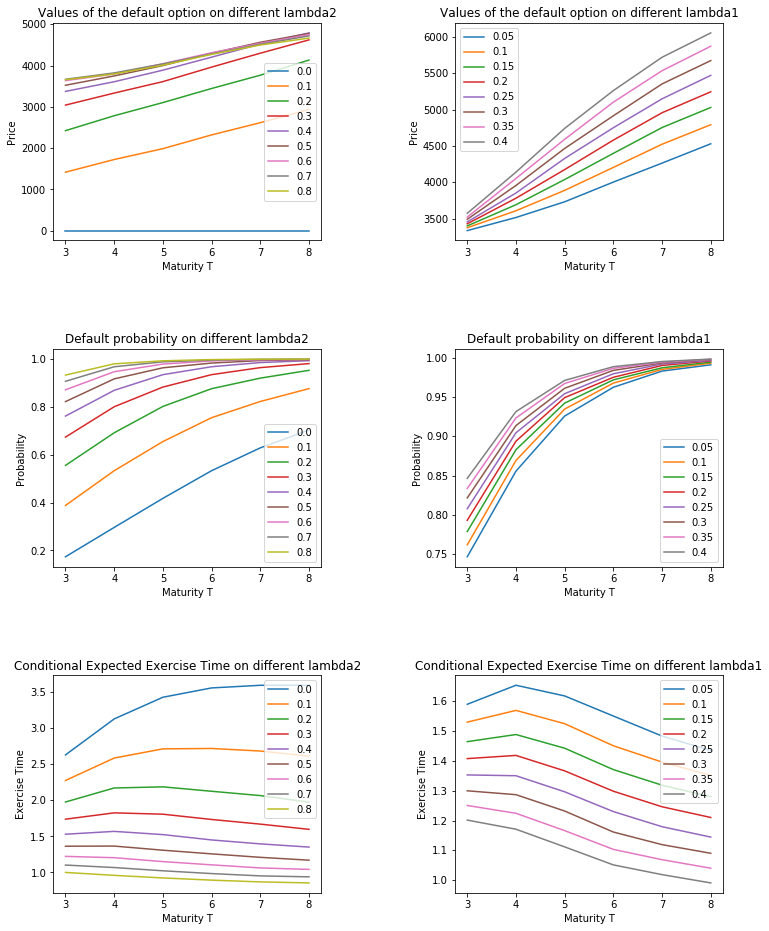

In [12]:
plt.figure()
plt.figure(figsize=(12,16))
plt.subplots_adjust(wspace=0.5,hspace =0.5)
plt.subplot(321)
for i in range(len(lambda2)):
    plt.plot(T2,value1[i,:])
plt.legend(labels=lambda2)
plt.xlabel("Maturity T")
plt.ylabel("Price")
plt.title("Values of the default option on different lambda2")
plt.subplot(322)
for i in range(len(lambda1)):
    plt.plot(T2,value2[i,:])
plt.legend(labels=lambda1)
plt.xlabel("Maturity T")
plt.ylabel("Price")
plt.title("Values of the default option on different lambda1")
plt.subplot(323)
for i in range(len(lambda2)):
    plt.plot(T2,ProbDefault1[i,:])
plt.legend(labels=lambda2)
plt.xlabel("Maturity T")
plt.ylabel("Probability")
plt.title("Default probability on different lambda2")
plt.subplot(324)
for i in range(len(lambda1)):
    plt.plot(T2,ProbDefault2[i,:])
plt.legend(labels=lambda1)
plt.xlabel("Maturity T")
plt.ylabel("Probability")
plt.title("Default probability on different lambda1")
plt.subplot(325)
for i in range(len(lambda2)):
    plt.plot(T2,EexerciseT1[i,:])
plt.legend(labels=lambda2)
plt.xlabel("Maturity T")
plt.ylabel("Exercise Time")
plt.title("Conditional Expected Exercise Time on different lambda2")
plt.subplot(326)
for i in range(len(lambda1)):
    plt.plot(T2,EexerciseT2[i,:])
plt.legend(labels=lambda1)
plt.xlabel("Maturity T")
plt.ylabel("Exercise Time")
plt.title("Conditional Expected Exercise Time on different lambda1")
plt.show()